# Hemnet Stockholm: Data Analysis and Price Prediction

This project explores the Stockholm real estate market using publicly available data from Hemnet.  

We start by **scraping sold apartment listings**, collecting information such as location, size, number of rooms, monthly fee, and sale price. Using this dataset, we create **interactive visualizations** to understand trends in average price per square meter across different neighborhoods over time.  

Finally, we build a **predictive model** that can estimate the selling price of an apartment based on its features, like size, number of rooms, balcony, and location. 

Scroll all the way to the bottom for the predictive model.


In [1]:
import cloudscraper
from bs4 import BeautifulSoup
import pandas as pd
import time
def scrape():
    scraper = cloudscraper.create_scraper()
    
    # define price and area intervals
    price_ranges = [(i, i + 250_000) for i in range(0, 25_000_000, 250_000)]
    price_ranges.append((25_000_000, 100_000_000))  # catch everything above 25M
    
    area_ranges = [(i, i + 5) for i in range(15, 450, 5)]
    
    all_listings = []
    chunk_size = 5000
    total_scraped = 0
    print("Starting scrape..")
    
    for price_min, price_max in price_ranges:
        for area_min, area_max in area_ranges:
            page = 1
            while True:
                url = (
                    f"https://www.hemnet.se/salda/bostader?"
                    f"price_min={price_min}&price_max={price_max}&"
                    f"living_area_min={area_min}&living_area_max={area_max}&"
                    f"item_types%5B%5D=bostadsratt&location_ids[]=18031&page={page}"
                )
                html = scraper.get(url).text
                soup = BeautifulSoup(html, "html.parser")
                
                cards = soup.select('span.Container_cardWrapper__ZE0kA')
                if not cards:
                    break  # no more listings on this page
                
                for card in cards:
                    try:
                        address = card.select_one('div.Location_address___eOo4 span').get_text(strip=True)
                    except:
                        address = None
                    try:
                        municipality = address.split(',')[-1].strip()
                    except:
                        municipality = None
                    try:
                        rooms_area = card.select('div.hcl-flex--container.hcl-flex--gap-2 p.Text_hclText__V01MM')
                        area = rooms_area[0].get_text(strip=True) if len(rooms_area) > 0 else None
                        rooms = rooms_area[1].get_text(strip=True) if len(rooms_area) > 1 else None
                    except:
                        area, rooms = None, None
                    try:
                        monthly_fee = card.select_one('div.hcl-flex--container.hcl-flex--gap-2 + span.Text_hclText__V01MM').get_text(strip=True)
                    except:
                        monthly_fee = None
                    try:
                        sold_price = card.select_one('div.SellingPriceAttributes_contentWrapper__VaxX9 span').get_text(strip=True)
                        price_per_m2 = card.select_one('div.SellingPriceAttributes_contentWrapper__VaxX9 p.Text_hclText__V01MM').get_text(strip=True)
                    except:
                        sold_price, price_per_m2 = None, None
                    try:
                        sold_date = card.select_one('li span.Label_hclLabelSoldAt__gw0aX').get_text(strip=True)
                    except:
                        sold_date = None
                    features = [li.get_text(strip=True) for li in card.select('ul.LabelsList_hclLabelsList__EeLb5 li span.Label_hclLabel__nITs3')]
                    balcony = any('balkong' in f.lower() for f in features)
                    
                    all_listings.append({
                        'address': address,
                        'municipality': municipality,
                        'area_m2': area,
                        'rooms': rooms,
                        'monthly_fee': monthly_fee,
                        'sold_price': sold_price,
                        'price_per_m2': price_per_m2,
                        'sold_date': sold_date,
                        'balcony': balcony
                    })
                
                total_scraped += len(cards)
                if total_scraped % 10000 < len(cards):
                    print(f"{total_scraped} listings scraped so far...")
                
                # save in chunks
                if len(all_listings) >= chunk_size:
                    df = pd.DataFrame(all_listings)
                    df.to_csv(
                        "hemnet_stockholm_scrape.csv",
                        mode='a',
                        index=False,
                        header=not pd.io.common.file_exists("hemnet_stockholm_scrape.csv")
                    )
                    all_listings = []
    
                page += 1
                time.sleep(0.1)  # polite pause
    
    # save any remaining listings
    if all_listings:
        df = pd.DataFrame(all_listings)
        df.to_csv(
            "hemnet_stockholm_scrape.csv",
            mode='a',
            index=False,
            header=not pd.io.common.file_exists("hemnet_stockholm_scrape.csv")
        )

# load and inspect
df1 = pd.read_csv("hemnet_stockholm_scrape_1.csv")
df2 = pd.read_csv("hemnet_stockholm_scrape_2.csv")

# Concatenate them into a single DataFrame
hemnet_df = pd.concat([df1, df2], ignore_index=True)
print(hemnet_df.shape)
print(hemnet_df.head())
print(hemnet_df.info())

print("Scraping completed!")


(347977, 9)
                                       address       municipality  area_m2  \
0  Bromma Brommaplan/Riksby, Stockholms kommun  Stockholms kommun    56 m²   
1          Hammarby Sjöstad, Stockholms kommun  Stockholms kommun  83,5 m²   
2           Hässelby Strand, Stockholms kommun  Stockholms kommun  67,5 m²   
3           Södermalm-Sofia, Stockholms kommun  Stockholms kommun    74 m²   
4                 Stockholm, Stockholms kommun  Stockholms kommun   131 m²   

     rooms   monthly_fee          sold_price price_per_m2          sold_date  \
0  2,5 rum  3 870 kr/mån  Slutpris230 000 kr  4 107 kr/m²  Såld 25 jun. 2016   
1    3 rum  4 494 kr/mån        Slutpris8 kr      0 kr/m²   Såld 5 feb. 2016   
2    3 rum  4 251 kr/mån  Slutpris275 000 kr  4 074 kr/m²  Såld 20 aug. 2020   
3    3 rum  3 039 kr/mån  Slutpris405 000 kr  5 473 kr/m²   Såld 7 apr. 2014   
4    4 rum  4 324 kr/mån  Slutpris400 000 kr  3 053 kr/m²   Såld 5 apr. 2022   

   balcony  
0    False  
1    False  

## Cleaning the Data

As you can see, scraping data can get messy. Some listings have missing fields, inconsistent formats for prices or areas, and extra characters that need to be removed.

Before we can analyze the data or build any predictive models, we need to **clean and standardize** it. This includes converting text to numeric values, handling missing data, and ensuring dates are in the right format.


In [4]:
def clean_hemnet(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df["area_m2"] = (
        df["area_m2"]
        .str.replace(",", ".", regex=False)
        .str.extract(r"(\d+\.?\d*)")
        .astype(float)
    )

    df["rooms"] = (
        df["rooms"]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .str.extract(r"(\d+\.?\d*)")
        .fillna("0")
        .astype(float)
    )
    
    df["monthly_fee"] = (
        df["monthly_fee"]
        .astype(str)
        .str.replace(r"[^\d]", "", regex=True)
        .replace("", "0")
        .astype(int)
    )

    df["sold_price"] = (
        df["sold_price"]
        .astype(str)
        .str.replace(r"[^\d]", "", regex=True)
        .replace("", "0")
        .astype(int)
    )

    df["price_per_m2"] = (
        df["price_per_m2"]
        .astype(str)
        .str.replace(r"[^\d]", "", regex=True)
        .replace("", "0")
        .astype(int)
    )

    df["sold_date"] = (
        df["sold_date"]
        .str.replace("Såld", "", case=False, regex=False)
        .str.strip()
        .str.replace("okt", "oct", case=False)
        .str.replace("maj", "may", case=False)
    )

    df["sold_date"] = pd.to_datetime(df["sold_date"], errors="coerce", dayfirst=True)


    return df

df_clean = clean_hemnet(hemnet_df)
print(df_clean.head())
print(df_clean.dtypes)
print(df_clean.info())

/tmp/ipykernel_4685/877604314.py:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["sold_date"] = pd.to_datetime(df["sold_date"], errors="coerce", dayfirst=True)


                                       address       municipality  area_m2  \
0  Bromma Brommaplan/Riksby, Stockholms kommun  Stockholms kommun     56.0   
1          Hammarby Sjöstad, Stockholms kommun  Stockholms kommun     83.5   
2           Hässelby Strand, Stockholms kommun  Stockholms kommun     67.5   
3           Södermalm-Sofia, Stockholms kommun  Stockholms kommun     74.0   
4                 Stockholm, Stockholms kommun  Stockholms kommun    131.0   

   rooms  monthly_fee  sold_price  price_per_m2  sold_date  balcony  
0    2.5         3870      230000          4107 2016-06-25    False  
1    3.0         4494           8             0 2016-02-05    False  
2    3.0         4251      275000          4074 2020-08-20     True  
3    3.0         3039      405000          5473 2014-04-07    False  
4    4.0         4324      400000          3053 2022-04-05    False  
address                 object
municipality            object
area_m2                float64
rooms             

## Visualizations

Now that we have clean data, we can start doing some visualizations. We start with a simple plot of **average price per m^2 over time**.

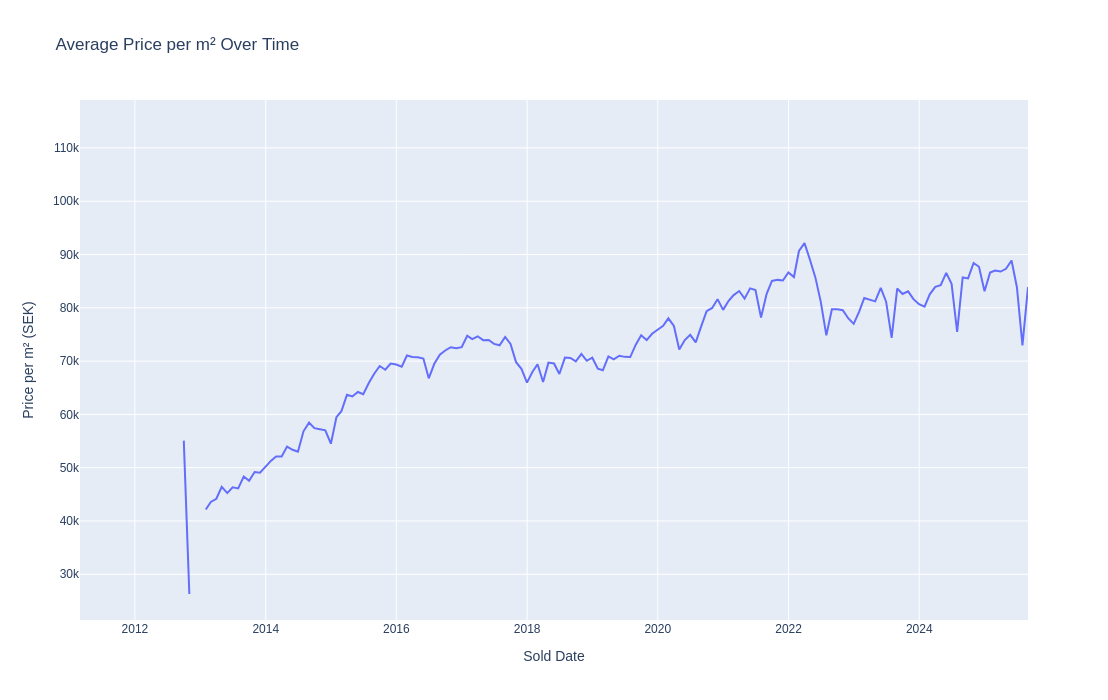

In [5]:
import plotly.express as px

# resample by month and compute mean price per m²
df_time = df_clean.set_index("sold_date")["price_per_m2"].resample("ME").mean().reset_index()

# create line plot
fig = px.line(
    df_time,
    x="sold_date",
    y="price_per_m2",
    title="Average Price per m² Over Time",
    labels={"sold_date": "Sold Date", "price_per_m2": "Price per m² (SEK)"},
    height=700  # increase the height
)

fig.show()


Next, we want to create a similar plot, but this time showing the data **grouped by location**. To do this, we first need to do a bit of processing to organize the location information.

In [6]:
with open("areas.txt", "r", encoding="utf-8") as f:
    content = f.read()

# convert string content to a dictionary
area_map = eval(content)

# apply mapping
for pattern, area in area_map.items():
    df_clean.loc[df_clean["address"].str.contains(pattern, case=False, na=False), "address"] = area

# remove trailing ", Stockholms kommun"
df_clean["address"] = df_clean["address"].str.replace(r", Stockholms kommun$", "", regex=True)

# count occurrences per address
counts = df_clean["address"].value_counts()

# keep only addresses with more than 50 entries
df_clean = df_clean[df_clean["address"].isin(counts[counts > 50].index)]

In [7]:
# define inner city neighborhoods
innerstan = ["Östermalm", "Södermalm", "Kungsholmen", "Vasastan", "Gamla Stan", "Norrmalm"]

# filter for 2024 and inner city
df_inner = df_clean[
    (df_clean["sold_date"].dt.year == 2024) &
    (df_clean["address"].isin(innerstan))
]

# scatter plot colored by neighborhood
fig = px.scatter(
    df_inner,
    x="area_m2",
    y="sold_price",
    color="address",
    opacity=0.6,
    hover_data=["address", "municipality", "rooms"],
    labels={"area_m2": "Area (m²)", "sold_price": "Sold Price (SEK)"}
)

fig.update_layout(
    title="Sold Price vs Apartment Area in Innerstan (2024)",
    height=600
)

fig.show()

In [8]:
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

df_filtered = df_clean[df_clean["sold_date"].dt.year >= 2013].copy()
df_filtered["price_per_m2"] = df_filtered["sold_price"] / df_filtered["area_m2"]
df_filtered["month"] = df_filtered["sold_date"].dt.to_period("M").dt.to_timestamp()

all_neighborhoods = sorted(df_filtered["address"].unique())
default_selection = {"Östermalm", "Södermalm", "Vasastan", "Kungsholmen"}

toggle_btn = widgets.ToggleButton(
    value=False,
    description="Select area ▼",
    button_style="info"
)

#grid of checkboxes
checkboxes = [
    widgets.Checkbox(
        value=(n in default_selection),
        description=n,
        layout=widgets.Layout(width="210px", height="22px")  # tighter height
    )
    for n in all_neighborhoods
]

checkbox_grid = widgets.GridBox(
    checkboxes,
    layout=widgets.Layout(
        grid_template_columns="repeat(6, 150px)",  
        grid_gap="2px 8px",
        display="none",
        overflow="visible",   # allow content to expand, no scroll
        max_height=None       # no height limit
    )
)

# plot
output = widgets.Output()

def toggle_menu(change):
    checkbox_grid.layout.display = "grid" if change["new"] else "none"
    toggle_btn.description = "Select area ▲" if change["new"] else "Select area ▼"

toggle_btn.observe(toggle_menu, "value")

def update_plot(change=None):
    selected = [cb.description for cb in checkboxes if cb.value]
    with output:
        output.clear_output()
        if not selected:
            print("Select at least one area.")
            return
        subset = df_filtered[df_filtered["address"].isin(selected)]
        avg_price = (
            subset.groupby(["month", "address"])["price_per_m2"]
            .mean()
            .reset_index()
        )
        fig = px.line(
            avg_price,
            x="month",
            y="price_per_m2",
            color="address",
            title="Average Price per m² Over Time",
            labels={
                "month": "Month",
                "price_per_m2": "Price per m² (SEK)",
                "address": "Area"
            },
            height=600
        )
        fig.show()

# auto-update when any checkbox changes
for cb in checkboxes:
    cb.observe(update_plot, "value")

display(widgets.VBox([toggle_btn, checkbox_grid, output]))
update_plot()

Above, you can select a number of locations to get them added to the plot.

# Predictive Model

The goal here is to estimate the **sold price of an apartment** based on features like its size, number of rooms, monthly fee, presence of a balcony, and location.

We use a **Random Forest Regressor**, a robust ensemble method that handles non-linear relationships well.  
To stabilize the prices, we train the model on the logarithm of the sold price, which helps manage the wide range of apartment prices.

Finally, at the end of this code block, we provide an **interactive widget** so you can input apartment details and instantly see an estimated sale price.

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from ipywidgets import interact, IntSlider, FloatSlider, Checkbox, Dropdown

# filter out recent data
recent_df = df_clean[df_clean['sold_date'] >= '2024-01-01'].copy()

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
address_encoded = encoder.fit_transform(recent_df[['address']])
address_df = pd.DataFrame(address_encoded, columns=encoder.get_feature_names_out(['address']), index=recent_df.index)

# pepare features and target (log-price)
X = pd.concat([
    recent_df[['area_m2', 'rooms', 'monthly_fee', 'balcony']].astype(float),
    address_df
], axis=1)

y = np.log1p(recent_df['sold_price'])  # log(1 + price) to stabilize

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train model
model = RandomForestRegressor(
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# evaluate model
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # convert back from log
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred))
print(f"RMSE on test set: {rmse:,.0f} SEK")

# predictor function
def predict_price(address, area_m2, rooms, balcony, monthly_fee):
    input_df = pd.DataFrame({
        'area_m2': [area_m2],
        'rooms': [rooms],
        'monthly_fee': [monthly_fee],
        'balcony': [float(balcony)]
    })
    
    for i, cat in enumerate(encoder.categories_[0]):
        input_df[f'address_{cat}'] = int(cat == address)
    
    # match training columns
    for col in X_train.columns:
        if col not in input_df.columns:
            input_df[col] = 0
    input_df = input_df[X_train.columns]
    
    price_log = model.predict(input_df)[0]
    price = np.expm1(price_log)
    print(f"Estimated sold price: {price:,.0f} SEK")

#widget!
interact(
    predict_price,
    address=Dropdown(options=encoder.categories_[0], description='Address:'),
    area_m2=FloatSlider(min=20, max=200, step=1, value=50, description='Size m²'),
    rooms=IntSlider(min=1, max=6, step=1, value=2, description='Rooms'),
    balcony=Checkbox(value=False, description='Balcony'),
    monthly_fee=IntSlider(min=0, max=15000, step=100, value=2000, description='Monthly fee')
)

RMSE on test set: 780,434 SEK


interactive(children=(Dropdown(description='Address:', options=('Akalla', 'Alvik', 'Annedal', 'Aspudden', 'Axe…

<function __main__.predict_price(address, area_m2, rooms, balcony, monthly_fee)>